In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/sample_submission.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/test.csv


In [2]:
# Most Important 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import spearmanr, kendalltau


# other
import missingno as msno
import os
import joblib
import tarfile
import urllib

## SKlearn
import xgboost as xgb
from sklearn import datasets

from keras.utils import np_utils
# Metrics
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, confusion_matrix , f1_score

# Preprocessing & Imputing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Validating and Tuning
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier , BaggingClassifier


### Tensorflow and Keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from xgboost import XGBClassifier

from numpy import nan

from sklearn.neural_network import MLPClassifier

from sklearn.multiclass import OneVsRestClassifier


`Features`
* ID - an ID for this instance
* Area - (A), The area of a bean zone and the number of pixels within its boundaries.
* Perimeter - (P), Bean circumference is defined as the length of its border.
* MajorAxisLength - (L), The distance between the ends of the longest line that can be drawn from a bean.
* MinorAxisLength - (l), The longest line that can be drawn from the bean while standing perpendicular to the main axis.
* AspectRatio - (K), Defines the relationship between L and l. ===> `Delete that (correlated)`
* Eccentricity - (Ec), Eccentricity of the ellipse having the same moments as the region.
* ConvexArea - (C), Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
* EquivDiameter - (Ed), The diameter of a circle having the same area as a bean seed area.
* Extent - (Ex), The ratio of the pixels in the bounding box to the bean area.
* Solidity - (S), Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
* Roundness - (R), Calculated with the following formula: (4piA)/(P^2) ===> `Delete that (correlated)`
* Compactness - (CO), Measures the roundness of an object: Ed/L  ===> `Delete that (correlated)`
* ShapeFactor1 - (SF1)
* ShapeFactor2 - (SF2)
* ShapeFactor3 - (SF3)
* ShapeFactor4 - (SF4)

`target`
* y - the class of the bean. It can be any of BARBUNYA, SIRA, HOROZ, DERMASON, CALI, BOMBAY, and SEKER.


In [3]:
## Loading the Dataset

train_data = pd.read_csv('../input/dry-beans-classification-iti-ai-pro-intake01/train.csv')

train_data.head()

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
0,0,58238,971.303,397.202654,186.945510,2.124697,0.882317,58977,272.306674,0.604756,0.987470,0.775723,0.685561,0.006820,0.000929,0.469994,0.998595,HOROZ
1,1,44515,757.601,265.590470,213.967453,1.241266,0.592420,44780,238.071960,0.771745,0.994082,0.974620,0.896387,0.005966,0.002376,0.803510,0.997370,SEKER
2,2,31662,653.783,239.902428,168.421505,1.424417,0.712136,32034,200.781748,0.801407,0.988387,0.930853,0.836931,0.007577,0.002293,0.700453,0.997737,DERMASON
3,3,38778,734.020,268.446281,184.061923,1.458456,0.727925,39208,222.201897,0.766137,0.989033,0.904439,0.827733,0.006923,0.002005,0.685142,0.999250,DERMASON
4,4,42530,775.403,281.212824,193.236878,1.455275,0.726511,43028,232.703412,0.729816,0.988426,0.888895,0.827499,0.006612,0.001912,0.684755,0.996507,SIRA


In [4]:
## show the datatypes and null of the data
train_data.info()  ## seems good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10834 non-null  int64  
 1   Area             10834 non-null  int64  
 2   Perimeter        10834 non-null  float64
 3   MajorAxisLength  10834 non-null  float64
 4   MinorAxisLength  10834 non-null  float64
 5   AspectRation     10834 non-null  float64
 6   Eccentricity     10834 non-null  float64
 7   ConvexArea       10834 non-null  int64  
 8   EquivDiameter    10834 non-null  float64
 9   Extent           10834 non-null  float64
 10  Solidity         10834 non-null  float64
 11  roundness        10834 non-null  float64
 12  Compactness      10834 non-null  float64
 13  ShapeFactor1     10834 non-null  float64
 14  ShapeFactor2     10834 non-null  float64
 15  ShapeFactor3     10834 non-null  float64
 16  ShapeFactor4     10834 non-null  float64
 17  y           

In [5]:
train_data.describe()

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000
mean,5416.500000,53095.675189,855.274892,320.036169,202.410342,1.581294,0.750588,53816.205926,253.123583,0.749937,0.987152,0.873647,0.800244,0.006559,0.001718,0.644139,0.995083
std,3127.650742,29542.542580,214.991122,85.961630,45.113965,0.244314,0.091481,29999.710739,59.433080,0.048949,0.004626,0.059344,0.061228,0.001127,0.000593,0.098268,0.004306
min,0.000000,20420.000000,524.932000,183.601165,129.576207,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.645368,0.002856,0.000564,0.416499,0.947687
25%,2708.250000,36343.500000,703.601250,253.501071,175.927024,1.432985,0.716250,36731.250000,215.113880,0.718778,0.985627,0.833479,0.763378,0.005888,0.001161,0.582747,0.993690
50%,5416.500000,44645.000000,793.739500,296.377365,192.525040,1.550761,0.764314,45148.000000,238.419335,0.760141,0.988290,0.883472,0.801428,0.006643,0.001700,0.642287,0.996397
75%,8124.750000,61295.000000,975.517500,376.068399,217.315195,1.703029,0.809450,62251.500000,279.362162,0.786871,0.990014,0.916883,0.834068,0.007268,0.002169,0.695670,0.997895
max,10833.000000,254616.000000,1985.370000,738.860153,450.926187,2.388873,0.908167,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.009897,0.003665,0.974767,0.999733


In [6]:
## look at the target
train_data['y'].unique()

array(['HOROZ', 'SEKER', 'DERMASON', 'SIRA', 'BARBUNYA', 'CALI', 'BOMBAY'],
      dtype=object)

In [7]:
## take a copy and drop correlated Features
## correlated Features ['AspectRation', 'roundness', 'Compactness'] and Others
train_new = train_data.copy()

### Stratified Shuffle Split to train and val


In [8]:
train_deep = train_data.copy()

train_total = train_data.copy()

total Data shape => (10834, 18)
train_set shape => (7583, 18)
val_set shape => (3251, 18)


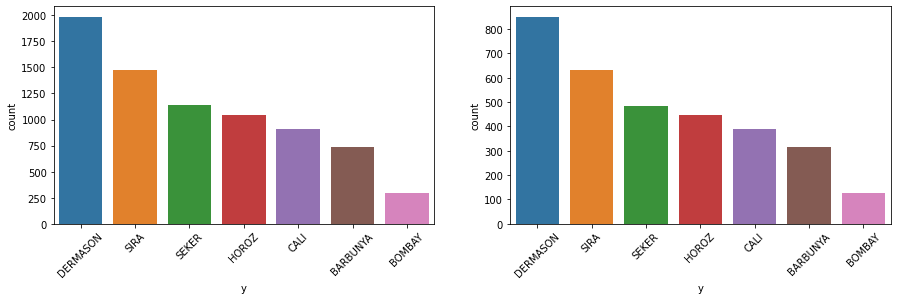

In [9]:
### split the data using that column using stratifiedMethod
split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
gen_for_indices = split_data.split(train_deep, train_deep['y'])

for train_idx, test_idx in gen_for_indices:
    train_set = train_deep.iloc[train_idx]
    val_set = train_deep.iloc[test_idx]
    
    
print('total Data shape =>', train_deep.shape)
print('=='*15)
print('train_set shape =>', train_set.shape) # 80 %
print('=='*15)
print('val_set shape =>', val_set.shape) # 20 %
print('=='*15)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

plt.sca(ax[0])
sns.countplot(x='y', data=train_set, order=train_set['y'].value_counts().index)
plt.xticks(rotation=45)

plt.sca(ax[1])
sns.countplot(x='y', data=val_set, order=val_set['y'].value_counts().index)
plt.xticks(rotation=45)
plt.show()  ### great work

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
y                  0

### for training data

In [10]:
X_train = train_set.drop(columns=['ID', 'y'], axis=1)
y_train = train_set['y']

x_total = train_total.drop(columns=['ID', 'y'], axis=1)

y_total = train_total['y']



## full_pipeline for numerical features

num_pipeline_deep = Pipeline([
                    
                    
                    ('scaler', MinMaxScaler()),
                   
                        ])

X_train_final = num_pipeline_deep.fit_transform(X_train)
X_train_final = pd.DataFrame(X_train_final)


############################
X_train_final2 = num_pipeline_deep.fit_transform(x_total)
X_train_final2 = pd.DataFrame(X_train_final2)

##########################

### Encoding the target ==> we are going to make multiclass classification
encoder_deep = LabelEncoder()
y_train_final = encoder_deep.fit_transform(y_train)

dummy_y = np_utils.to_categorical(y_train_final)



############################

encoder_total = LabelEncoder()

y_total_final2 = encoder_total.fit_transform(y_total)

dummy_y_total = np_utils.to_categorical(y_total_final2)


##########################

print('unique values of target =>', np.unique(dummy_y_total))
print('shape of target =>', y_train_final.shape) ## ok

dummy_y_total

unique values of target => [0. 1.]
shape of target => (7583,)


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
X_train_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.107636,0.173102,0.146667,0.279251,0.123640,0.447309,0.104763,0.195491,0.713017,0.940893,0.919746,0.790396,0.419382,0.608418,0.756334,0.994760
1,0.179576,0.339330,0.423946,0.191212,0.854924,0.971086,0.176179,0.295976,0.785460,0.877888,0.530301,0.083093,0.546900,0.091958,0.067428,0.887131
2,0.265064,0.410015,0.454406,0.358029,0.549390,0.871694,0.263042,0.399021,0.591309,0.761758,0.664938,0.293712,0.344864,0.139246,0.251060,0.717070
3,0.185955,0.329591,0.409953,0.217396,0.757291,0.946369,0.181683,0.304190,0.205319,0.914715,0.610578,0.145566,0.507405,0.114707,0.119994,0.872682
4,0.047896,0.100234,0.129033,0.089654,0.422886,0.802343,0.046958,0.096682,0.524810,0.894484,0.787770,0.421882,0.740250,0.431583,0.371735,0.935567


### for validating


In [12]:
X_val = val_set.drop(columns=['ID', 'y'], axis=1)
y_val = val_set['y']

X_val_final = num_pipeline_deep.transform(X_val)
X_val_final = pd.DataFrame(X_val_final)

y_val_final = encoder_deep.transform(y_val)

dummy_valy = np_utils.to_categorical(y_val_final)

print('unique values of target =>', np.unique(y_val_final))
print('shape of target =>', y_val_final.shape) ## ok

unique values of target => [0 1 2 3 4 5 6]
shape of target => (3251,)


In [13]:
m_poly = PolynomialFeatures(degree=4)

x_poly = m_poly.fit_transform(X_train_final)
x_poly.shape

(7583, 4845)

In [14]:
snn_classifier = MLPClassifier()
snn_classifier.fit(X_train_final, y_train_final)


predict = snn_classifier.predict(X_val_final)

print(classification_report(y_val_final, predict, target_names=['HOROZ', 'SEKER', 'DERMASON', 'SIRA', 'BARBUNYA', 'CALI', 'BOMBAY']))


# Generate the confusion matrix and classification report
print(confusion_matrix(y_val_final, predict))
print(classification_report(y_val_final, predict))


print(f1_score(y_val_final, predict, average='micro'))

              precision    recall  f1-score   support

       HOROZ       0.93      0.91      0.92       317
       SEKER       1.00      1.00      1.00       126
    DERMASON       0.94      0.94      0.94       391
        SIRA       0.91      0.92      0.91       851
    BARBUNYA       0.94      0.96      0.95       447
        CALI       0.97      0.92      0.94       486
      BOMBAY       0.86      0.87      0.86       633

    accuracy                           0.92      3251
   macro avg       0.94      0.93      0.93      3251
weighted avg       0.92      0.92      0.92      3251

[[290   0  18   0   2   3   4]
 [  0 126   0   0   0   0   0]
 [ 10   0 369   0   8   0   4]
 [  0   0   0 783   4   3  61]
 [  2   0   3   6 430   0   6]
 [  8   0   0  14   0 447  17]
 [  3   0   1  58  12   8 551]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       317
           1       1.00      1.00      1.00       126
           2       0.9

In [15]:
dnns_classifier = OneVsRestClassifier(MLPClassifier())
dnns_classifier.fit(X_train_final, y_train_final)

predict = dnns_classifier.predict(X_val_final)

print(classification_report(y_val_final, predict, target_names=['HOROZ', 'SEKER', 'DERMASON', 'SIRA', 'BARBUNYA', 'CALI', 'BOMBAY']))

predict = dnns_classifier.predict(X_val_final)
print(f1_score(y_val_final, predict, average='micro'))

              precision    recall  f1-score   support

       HOROZ       0.94      0.88      0.91       317
       SEKER       1.00      1.00      1.00       126
    DERMASON       0.92      0.95      0.93       391
        SIRA       0.91      0.92      0.91       851
    BARBUNYA       0.95      0.96      0.96       447
        CALI       0.97      0.93      0.95       486
      BOMBAY       0.85      0.87      0.86       633

    accuracy                           0.92      3251
   macro avg       0.93      0.93      0.93      3251
weighted avg       0.92      0.92      0.92      3251

0.919409412488465


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [16]:
# svm_clf = Pipeline([
#     ("poly_features", PolynomialFeatures(degree=3)),
#     ("scaler", ),
#     ("svm_cls", )
# ])


svm_clf = SVC(kernel='poly', degree=4, coef0=1, C=100, gamma=0.01, random_state=42, probability=True)

svm_clf.fit(X_train_final, y_train_final)

predict = svm_clf.predict(X_val_final)

print(classification_report(y_val_final, predict, target_names=['HOROZ', 'SEKER', 'DERMASON', 'SIRA', 'BARBUNYA', 'CALI', 'BOMBAY']))

predict = svm_clf.predict(X_val_final)
print(f1_score(y_val_final, predict, average='micro'))

              precision    recall  f1-score   support

       HOROZ       0.94      0.89      0.91       317
       SEKER       1.00      1.00      1.00       126
    DERMASON       0.92      0.95      0.94       391
        SIRA       0.92      0.93      0.92       851
    BARBUNYA       0.95      0.96      0.95       447
        CALI       0.97      0.93      0.95       486
      BOMBAY       0.86      0.88      0.87       633

    accuracy                           0.93      3251
   macro avg       0.94      0.93      0.94      3251
weighted avg       0.93      0.93      0.93      3251

0.9252537680713626


In [17]:

RF_cls = RandomForestClassifier(max_depth=64, n_estimators=145)

RF_cls.fit(X_train_final, y_train_final)


# cross_val_score(RF_cls, X_val_final, y_val_final, cv=3, scoring="accuracy").mean()


# max_depth=[64 , 65 , 62]
# n_estimators = [64]
# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# # Build the grid search
# dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
# grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
# grid.fit(X_train_final, y_train_final)

# best --> max_depth=16, n_estimators=64

predict = RF_cls.predict(X_val_final)
print(f1_score(y_val_final, predict, average='micro'))

0.927406951707167


In [18]:
# grid.best_estimator_

In [19]:
# RF_cls.feature_importances_

In [20]:
knn_clf = KNeighborsClassifier()


# parameters = {'n_neighbors':[11],
#               'n_jobs':[-1]}

# #Fit the model
# modelgrid = GridSearchCV(knn_clf, param_grid=parameters)
# modelgrid.fit(X_train_final, y_train_final)

# #predictions on test data
# modelgrid.best_params_

knn_clf.fit(X_train_final, y_train_final)

# best --> n_neighbors=14 , n_jobs=-1


# cross_val_score(knn_clf, X_val_final, y_val_final, cv=3, scoring="accuracy").mean()

predict = knn_clf.predict(X_val_final)
print(f1_score(y_val_final, predict, average='micro'))

0.9154106428791141


In [21]:
Baggingclf = BaggingClassifier(base_estimator=SVC(kernel='poly', degree=4, coef0=1, C=100, gamma=0.001), n_estimators=200)
Baggingclf.fit(X_train_final, y_train_final)

predict = Baggingclf.predict(X_val_final)
print(f1_score(y_val_final, predict, average='micro'))

0.9175638265149185


In [22]:
voting_clf =  VotingClassifier(
                                estimators=[('SVC', svm_clf), ('RF', RF_cls) ] , voting='soft')

voting_clf.fit(X_train_final, y_train_final)


predict = voting_clf.predict(X_val_final)
print(f1_score(y_val_final, predict, average='micro'))

0.9286373423561981


In [23]:
# def get_stacking():
#     # define the base models
#     level0 = list()
#     level0.append(('Bagging', BaggingClassifier(base_estimator=SVC(), n_estimators=10)))
#     level0.append(('svm', SVC( C=100, gamma=0.01)))
#     level0.append(('XGB', XGBClassifier(aplha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.6, gamma=2, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.05, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=100, n_jobs=8, num_parallel_tree=1,
#               objective='multi:softprob', random_state=0, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=None, subsample=1.0,
#               tree_method='exact', validate_parameters=1, verbosity=None)))
#     # define meta learner model
#     level1 = LogisticRegression()
#     # define the stacking ensemble
#     model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
#     return model

In [24]:
# y_train_final

In [25]:
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import StackingClassifier
# from matplotlib import pyplot


# # get a stacking ensemble of models
# def get_stacking():
# 	# define the base models
# 	level0 = list()
# 	level0.append(('knn', KNeighborsClassifier()))
# 	level0.append(('svm', SVC()))
# 	level0.append(('bayes', GaussianNB()))
# 	# define meta learner model
# 	level1 = LogisticRegression()
# 	# define the stacking ensemble
# 	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# 	return model

# # get a list of models to evaluate
# def get_models():
# 	models = dict()
# 	models['knn'] = KNeighborsClassifier()
# 	models['svm'] = SVC()
# 	models['bayes'] = GaussianNB()
# 	models['stacking'] = get_stacking()
# 	return models

# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# 	return scores

# # define dataset
# X, y = X_train_final, y_train_final
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, X, y)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

In [26]:


# para_tunning = {
#         'learning_rate': [0.01,0.05,0.1],
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#         "n_estimators": [100, 200, 300, 400, 500],
#         "objective": "multi:softmax",
#         "aplha":[0,2,4,6,8]
#         }

# clf_rndcv = RandomizedSearchCV(xg_model, 
#                          param_distributions = para_tunning,
#                          cv = 5,  
#                          n_iter = 5,
#                          scoring = 'accuracy', 
#                          error_score = 0, 
#                          verbose = 3, 
#                          n_jobs = -1,
#                          random_state = 42)

# clf_rndcv.fit(X_train_final, y_train_final)


In [27]:
# xgb_classifier = OneVsRestClassifier(XGBClassifier())
# xgb_classifier.fit(X_train_final, y_train_final)
# cross_val_score(xgb_classifier, X_val_final, y_val_final, cv=3, scoring="accuracy").mean()

In [28]:
# xg_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.6, gamma=2, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.05, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=100, n_jobs=8, num_parallel_tree=1,
#               objective='mlogloss', random_state=42, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=None, subsample=1.0,
#               tree_method='exact', validate_parameters=1, verbosity=None,use_label_encoder=False)

# # xg_model.fit(X_train_final, y_train_final)


In [29]:
# cross_val_score(xg_model, X_val_final, y_val_final, cv=3, scoring="accuracy")

In [30]:
# param_grid = {'C': [100,120,130,140, 150,160,170,180,190,200], 'gamma': [0.01,0.001,.0001,.0008]}
# grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
# grid.fit(X_train_final, y_train_final)


In [31]:
# print(grid.best_estimator_)

In [32]:
# rbf = SVC(kernel='rbf', gamma=0.001, C=100).fit(X_train_final2, y_total_final2)
# poly = SVC(kernel='poly', degree=3, C=100).fit(X_train_final, y_train_final)

# print(cross_val_score(rbf, X_val_final, y_val_final, cv=3, scoring="accuracy"))
# print(cross_val_score(poly, X_val_final, y_val_final, cv=3, scoring="accuracy"))

In [33]:
# svm_clf.fit(X_train_final, y_train_final)

In [34]:
# cross_val_score(svm_clf, X_val_final, y_val_final, cv=3, scoring="accuracy")

#array([0.92986342, 0.92654116, 0.92282127])  .75

#array([0.92081949, 0.92912514, 0.92520776])  .5

# array([0.93401015, 0.91785879, 0.92293493]) .6

# array([0.92009494, 0.92721519, 0.93275316]) .7   yes 

# array([0.92049051, 0.92919304, 0.93393987]) c = 150

# array([0.9244462 , 0.92761076, 0.93235759]) .7 yes  C=180, gamma=0.01 yes

In [35]:
### Building the Model

model = Sequential()
model.add(Dense(16, activation='relu', input_dim=16))


model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))


model.add(Dense(7, activation='softmax'))

In [36]:
# model = Sequential()
# model.add(Dense(128, input_dim = 16 , activation = 'relu'))
# model.add(Dense(60, activation = 'relu'))
# model.add(Dense(50, activation = 'relu'))
# model.add(Dense(40, activation = 'relu'))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dense(7, activation = 'softmax'))


In [37]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
early_stopp = EarlyStopping(patience=7, restore_best_weights=True, monitor='loss')

In [39]:
# history = model.fit(X_train_final, dummy_y, epochs=100, 
#                     validation_data=(X_val_final, dummy_valy),batch_size=128, callbacks=[early_stopp])

# history = model.fit(X_train_final2, dummy_y_total, epochs=200,batch_size=128,callbacks=[early_stopp],validation_split=.2)

In [40]:
# model.evaluate(X_val_final, dummy_valy)

In [41]:
# ### extract results from history


# train_loss = history.history['loss']
# train_acc = history.history['accuracy']

# val_loss = history.history['val_loss']
# val_acc = history.history['val_accuracy']
# epochs = range(1, len(train_loss)+1)

In [42]:
# ### get some results and Visualization from history
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# fig.tight_layout(pad=4)  ## to avoid overlaping of titles in subplots (try comment it you will know)

# plt.sca(ax[0])
# plt.plot(epochs, train_loss, 'bo-', label='training')
# plt.plot(epochs, val_loss, 'go--', label='validating')
# plt.xlabel('epochs')
# plt.ylabel('losses')
# plt.title('Training& ValidatingLoss')
# plt.legend()

# plt.sca(ax[1])
# plt.plot(epochs, train_acc, 'bo-', label='training')
# plt.plot(epochs, val_acc, 'go--', label='validating')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.title('Training & Validating Accuracy')

# plt.legend(loc='lower right')
# plt.show()

## Evaluating on Test Data

In [43]:
test_data = pd.read_csv('../input/dry-beans-classification-iti-ai-pro-intake01/test.csv')
test_data.head()

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,10834,57659,955.434,387.757607,196.625782,1.972059,0.861896,60188,270.949661,0.620790,0.957982,0.793735,0.698760,0.006725,0.000989,0.488266,0.962889
1,10835,28772,630.362,229.990785,159.609367,1.440960,0.719993,29127,191.399185,0.767458,0.987812,0.909913,0.832204,0.007994,0.002365,0.692563,0.997956
2,10836,54677,911.022,308.853903,226.398571,1.364204,0.680198,55858,263.850182,0.753013,0.978857,0.827860,0.854288,0.005649,0.001856,0.729808,0.995607
3,10837,24827,578.304,214.192699,147.788172,1.449322,0.723831,25121,177.794033,0.716508,0.988297,0.932871,0.830066,0.008627,0.002526,0.689009,0.998596
4,10838,141850,1432.847,524.923471,346.910920,1.513136,0.750492,143680,424.981211,0.804617,0.987263,0.868240,0.809606,0.003701,0.000981,0.655462,0.991803


In [44]:
X_test = test_data.drop(columns=['ID'], axis=1)


X_test_final = num_pipeline_deep.transform(X_test)
X_test_final = pd.DataFrame(X_test_final)

In [45]:
nums_predictions = voting_clf.predict(X_test_final)
nums_predictions

array([4, 3, 0, ..., 4, 3, 6])

In [46]:
y_names_predictions = encoder_deep.inverse_transform(nums_predictions)
y_names_predictions

array(['HOROZ', 'DERMASON', 'BARBUNYA', ..., 'HOROZ', 'DERMASON', 'SIRA'],
      dtype=object)

In [47]:
test_data['y'] = y_names_predictions

test_data[['ID', 'y']]

,ID,y
0,10834,HOROZ
1,10835,DERMASON
2,10836,BARBUNYA
3,10837,DERMASON
4,10838,BOMBAY
...,...,...
2704,13538,CALI
2705,13539,SEKER
2706,13540,HOROZ
2707,13541,DERMASON


In [48]:
test_data[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)